# **1 - Import Library**

In [ ]:
# Setup connection with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import shap
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# **2 - Chuẩn bị dữ liệu**

In [ ]:
# Read file
df = pd.read_csv("/content/drive/Shareddrives/ADA || PHÂN TÍCH DỮ LIỆU NÂNG CAO/ADA || FINAL PROJECT/Data/FP_Data_IBM_HR_Employee_Attrition.csv")

## **2.1 - Data Cleaning and Type correction**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

*Some variables such as EmployeeCount, Over18, and StandardHour only have one value --> these are needed to analyze deeper. And also EmployeeNumber, it might be the Employee's identity*

Drop EmployeeCount, Over18, and StandardHour and Number because

- Unique values = 1 --> no variance
- Correlation = NaN --> no relationships with attrition
- Frequency distributions = constant --> no insight
- EmployeeNumber -> is a employee identify

--> Conclusion: these do not provide any insights, it might be a placeholder

In [ ]:
df = df.drop(['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

In [ ]:
# Convert target variables
df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})
df["Attrition"].value_counts()

,count
Attrition,
0,1233
1,237


# **Overall workflow**
1. Data Splitting
2. Encoding data
3. Scaling
4. Feature Selection
- Filter method: Correlation matrix (Only for original numeric features)
- Wrapper method: RFE (Logistic Regression)
- Embedded method: Random Forest
5. Handle Imbalance class: SMOTE and Class Weight
6. Predict
7. Evaluate

Giải thích:
- Chia train test trước khi encoding, scaling và feature selection để tránh data leakage: Đọc thêm tại: [Scikit-learn](https://scikit-learn.org/stable/common_pitfalls.html), [TowardScience](https://towardsdatascience.com/3-key-encoding-techniques-for-machine-learning-a-beginner-friendly-guide-aff8a01a7b6a/), [DataBrick](https://community.databricks.com/t5/machine-learning/do-one-hot-encoding-ohe-before-or-after-split-data-to-train-and/td-p/17888), [Geeks](https://www.geeksforgeeks.org/machine-learning/feature-selection-techniques-in-machine-learning/)
- Sử dụng correlation (chỉ cho các biến numeric ban đầu) -> loại biến -> RFE chọn ra 20 biến -> Embedded method chọn ra 10 biến (Tham khảo ở Geeks và tài liệu hướng dẫn của Thầy)


## **1. Data Splitting(Stratify)**

In [ ]:
# Define Features (X) and Target (y)
# Split Data (80% Train, 20% Test)
df1 = df.copy()
X = df1.drop(columns=["Attrition"])
y = df1["Attrition"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f" Data Split Completed:")
print(f" Training Set: {X_train.shape}")
print(f" Testing Set:  {X_test.shape}")

 Data Split Completed:
 Training Set: (1176, 30)
 Testing Set:  (294, 30)


## **2. Encoding data**

In [ ]:
# Define the numeric columns before encoding
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

print(X_train.shape)
print(X_test.shape)
# Encoding features
categorical_cols = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime"
]

X_train_encoded = pd.get_dummies(
    X_train,
    columns=categorical_cols,
    drop_first=True
)

X_test_encoded = pd.get_dummies(
    X_test,
    columns=categorical_cols,
    drop_first=True
)

# Align test to train
X_test_encoded = X_test_encoded.reindex(
    columns=X_train_encoded.columns,
    fill_value=0
)
print(X_train_encoded.shape)
print(X_test_encoded.shape)


(1176, 30)
(294, 30)
(1176, 44)
(294, 44)


## **3. Scaling**

In [ ]:
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()
scaler = StandardScaler()
X_train_scaled[num_cols] = scaler.fit_transform(X_train_encoded[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test_encoded[num_cols])

## **4. Feature selection**

### **Filter method: Correlation matrix**

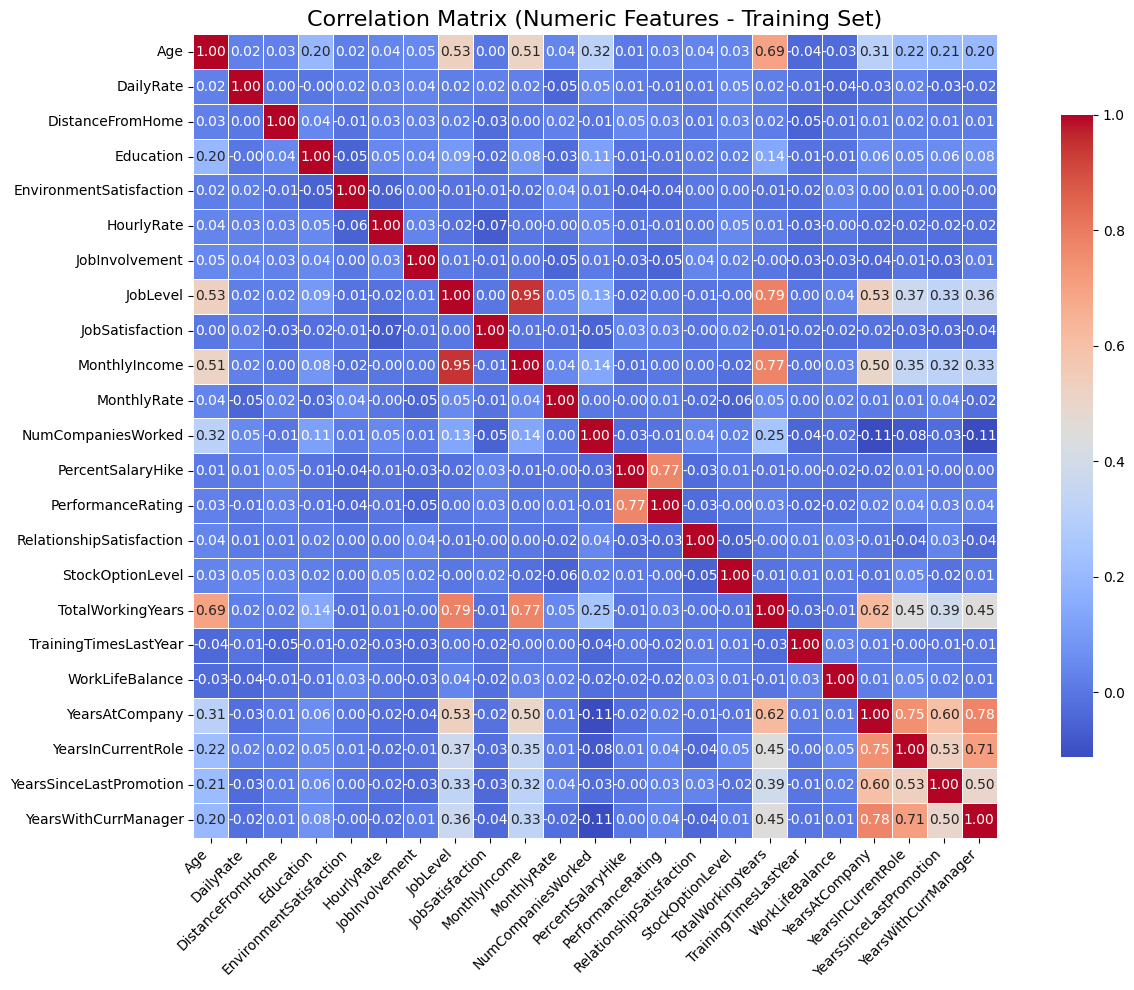

In [ ]:
# Compute correlation matrix
corr_matrix = X_train_scaled[num_cols].corr()

# Plot
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix (Numeric Features - Training Set)", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


- Các biến như DailyRate, HourlyRate, MonthlyRate có tương quan yếu với các biến còn lại --> drop

- Biến YearAtCompany có tương quan cao với YearsWithCurrManager(0.78), YearsWithCurrentRole(0.75), YearsSinceLastPromotion(0.6)
-> Giữ biến YearsAtCompany, drop 3 biến còn lại

- Biến MonthlyIncome có tương quan cao với JobLevel (0.95) và giữa PerformanceRating và PercentSalaryHike (0.77) -> Drop MonthlyIncome, giữ JobLevel (biến phân loại, giữ để diễn giải) - Drop PerformanceRating bởi vì biến này thường liên quan đến chính sách bên HR

- Biến TotalWorkingYears có tương quan cao với MonthlyIncome(0.77), JobLevel (0.79), và Age (0.69) -> Đã drop MonthlyIncome ở trên, drop thêm biến Age, giữ lại JobLevel như trên



In [ ]:
cols_to_drop = [
    "DailyRate", "HourlyRate", "MonthlyRate",
    "YearsWithCurrManager", "YearsInCurrentRole",
    "YearsSinceLastPromotion", "MonthlyIncome",
    "PerformanceRating", "Age"
]

X_train = X_train_scaled.drop(columns=cols_to_drop)
X_test  = X_test_scaled.drop(columns=cols_to_drop)


### **Wrapper method: RFE (Logistic Regression)**

In [ ]:
log_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
n_features = 20

rfe = RFE(
    estimator=log_model,
    n_features_to_select=n_features
)

rfe.fit(X_train, y_train)

selected_features_rfe = X_train.columns[rfe.support_]

print("Selected Features (RFE):")
print(selected_features_rfe)

X_train_rfe = X_train[selected_features_rfe]
X_test_rfe  = X_test[selected_features_rfe]

Selected Features (RFE):
Index(['EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'NumCompaniesWorked', 'TotalWorkingYears',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Life Sciences', 'EducationField_Medical',
       'EducationField_Other', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Representative',
       'MaritalStatus_Single', 'OverTime_Yes'],
      dtype='object')


### **Embedded method: Random Forest**


In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_rfe, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)

In [ ]:
feature_importance = pd.DataFrame({
    "Feature": X_train_rfe.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Top 10 Most Important Features (Random Forest):")
print(feature_importance.head(10))

Top 10 Most Important Features (Random Forest):
                             Feature  Importance
5                  TotalWorkingYears    0.184281
4                 NumCompaniesWorked    0.114411
3                    JobSatisfaction    0.087828
0            EnvironmentSatisfaction    0.087791
2                           JobLevel    0.081793
19                      OverTime_Yes    0.077813
1                     JobInvolvement    0.067853
18              MaritalStatus_Single    0.048946
11            EducationField_Medical    0.032535
6   BusinessTravel_Travel_Frequently    0.030912


In [ ]:
top_10_features = feature_importance["Feature"].head(10)

X_train_final = X_train_rfe[top_10_features]
X_test_final  = X_test_rfe[top_10_features]

## **5. Handle Imbalance class: SMOTE and Class Weight**


### **SMOTE**

In [ ]:
smote = SMOTE(random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(
    X_train_final,
    y_train
)

# Logisic Regression
log_sm = LogisticRegression(
    max_iter=1000,
    random_state=42
)
log_sm.fit(X_train_sm, y_train_sm)

# Decision Tree
dt_sm = DecisionTreeClassifier(random_state=42)
dt_sm.fit(X_train_sm, y_train_sm)

# Random Forest
rf_sm = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf_sm.fit(X_train_sm, y_train_sm)

# XGBoost
xgb_sm = XGBClassifier(
    n_estimators=300,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False
)

xgb_sm.fit(X_train_sm, y_train_sm)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [16:13:57] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

### **Class weight**

In [ ]:
# Logistic Regression
log_weight = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
log_weight.fit(X_train_final, y_train)

# Decision Tree
dt_weight = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=42
)

dt_weight.fit(X_train_final, y_train)

# Random Forest
rf_weight = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_weight.fit(X_train_final, y_train)


# XGBoost
neg, pos = y_train.value_counts()
scale_weight = neg / pos
xgb_weight = XGBClassifier(
    n_estimators=300,
    scale_pos_weight=scale_weight,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False
)
xgb_weight.fit(X_train_final, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [16:13:58] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

## **6. Predict**

### **Class weight**

In [ ]:
# Logistic Regression
y_pred_log_w = log_weight.predict(X_test_final)
y_prob_log_w = log_weight.predict_proba(X_test_final)[:, 1]

# Decision Tree
y_pred_dt_w = dt_weight.predict(X_test_final)
y_prob_dt_w = dt_weight.predict_proba(X_test_final)[:, 1]

# Random Forest
y_pred_rf_w = rf_weight.predict(X_test_final)
y_prob_rf_w = rf_weight.predict_proba(X_test_final)[:, 1]

# XGBoost
y_pred_xgb_w = xgb_weight.predict(X_test_final)
y_prob_xgb_w = xgb_weight.predict_proba(X_test_final)[:, 1]

### **SMOTE**

In [ ]:
# Logistic Regression
y_pred_log_sm = log_sm.predict(X_test_final)
y_prob_log_sm = log_sm.predict_proba(X_test_final)[:, 1]

# Decision Tree
y_pred_dt_sm = dt_sm.predict(X_test_final)
y_prob_dt_sm = dt_sm.predict_proba(X_test_final)[:, 1]

# Random Forest
y_pred_rf_sm = rf_sm.predict(X_test_final)
y_prob_rf_sm = rf_sm.predict_proba(X_test_final)[:, 1]

# XGBoost
y_pred_xgb_sm = xgb_sm.predict(X_test_final)
y_prob_xgb_sm = xgb_sm.predict_proba(X_test_final)[:, 1]


## **7. Evaluate**

In [ ]:
def evaluate_model(name, y_true, y_pred, y_prob):
    print(f"\n{name}")
    print(classification_report(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))

evaluate_model("Logistic (Weight)", y_test, y_pred_log_w, y_prob_log_w)
evaluate_model("Logistic (SMOTE)", y_test, y_pred_log_sm, y_prob_log_sm)
print("======================================================================")
evaluate_model("Decision Tree (Weight)", y_test, y_pred_dt_w, y_prob_dt_w)
evaluate_model("Decision Tree (SMOTE)", y_test, y_pred_dt_sm, y_prob_dt_sm)
print("======================================================================")
evaluate_model("Random Forest (Weight)", y_test, y_pred_rf_w, y_prob_rf_w)
evaluate_model("Random Forest (SMOTE)", y_test, y_pred_rf_sm, y_prob_rf_sm)
print("======================================================================")
evaluate_model("XGBoost (Weight)", y_test, y_pred_xgb_w, y_prob_xgb_w)
evaluate_model("XGBoost (SMOTE)", y_test, y_pred_xgb_sm, y_prob_xgb_sm)




Logistic (Weight)
              precision    recall  f1-score   support

           0       0.94      0.75      0.84       247
           1       0.37      0.77      0.50        47

    accuracy                           0.76       294
   macro avg       0.66      0.76      0.67       294
weighted avg       0.85      0.76      0.78       294

ROC-AUC: 0.8205702472219829

Logistic (SMOTE)
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       247
           1       0.39      0.74      0.51        47

    accuracy                           0.77       294
   macro avg       0.67      0.76      0.68       294
weighted avg       0.85      0.77      0.80       294

ROC-AUC: 0.823240589198036

Decision Tree (Weight)
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       247
           1       0.29      0.34      0.31        47

    accuracy                           0.76       294
   macro avg

1. Logistic Regression: Cả hai phương pháp đều cho kết quả tương tự. SMOTE mang lại một chút cải thiện về Accuracy/F1, trong khi phương pháp class weight mang lại chỉ số Recall cao hơn một chút.

2. Decision Tree: cả 2 phương pháp mang lại kết quả đều thấp, mô hình hoạt động kém ngay cả khi đã xử lý imbalance = SMOTE

3. Random Forest: SMOTE giúp cải thiện Recall và F1-Score cho nhóm thiểu số (Attrition = 1) mặc dù Accuracy giảm nhẹ (từ 0.83 xuống 0.81), còn ROC-AUC thì ổn định

4. XGBoost: kết quả ở 2 phương pháp khá tương dồng, SMOTE giúp cải thiện độ F1-Score hơn một xíu nhưng không đáng kể

**Kết luận: Chọn Logistic Regression (SMOTE) là model tốt nhất trong trường hợp này**

## **ERROR ANALYSIS**

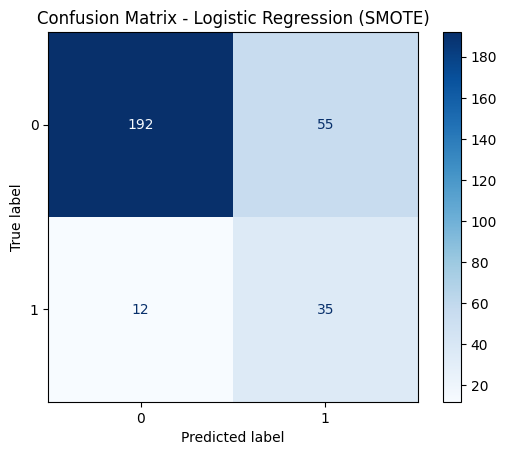

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_log_sm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression (SMOTE)")
plt.show()

## **INTEPRETATION ANALYSIS**

In [ ]:
coefficients = log_sm.coef_[0]

coef_df = pd.DataFrame({
    "Feature": X_train_final.columns,
    "Coefficient": coefficients
})

coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()

coef_df = coef_df.sort_values(
    by="Abs_Coefficient",
    ascending=False
).reset_index(drop=True)

print(coef_df)

                            Feature  Coefficient  Abs_Coefficient
0                      OverTime_Yes     1.987555         1.987555
1              MaritalStatus_Single     1.291052         1.291052
2  BusinessTravel_Travel_Frequently     1.272668         1.272668
3                 TotalWorkingYears    -0.940135         0.940135
4                   JobSatisfaction    -0.453245         0.453245
5                NumCompaniesWorked     0.423912         0.423912
6           EnvironmentSatisfaction    -0.396155         0.396155
7            EducationField_Medical     0.322360         0.322360
8                    JobInvolvement    -0.255959         0.255959
9                          JobLevel    -0.023787         0.023787


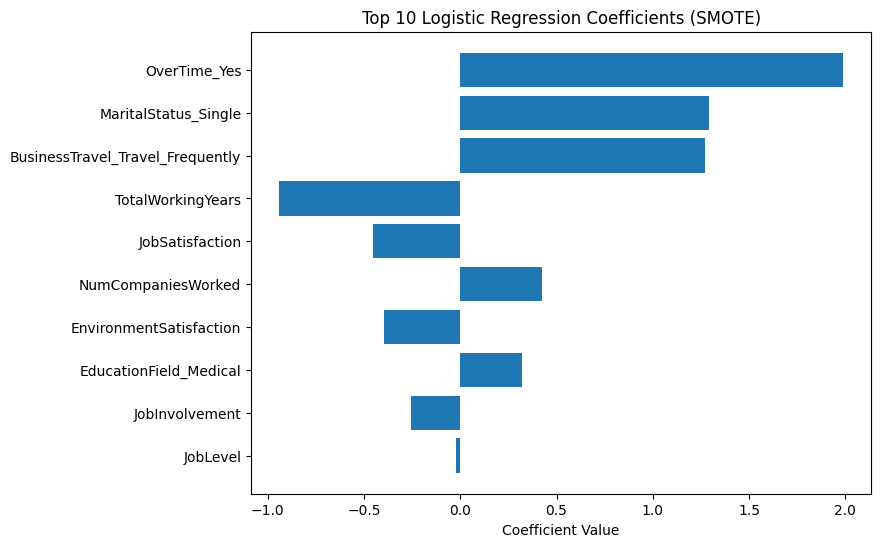

In [ ]:
top_n = 10
top_coef = coef_df.head(top_n)

plt.figure(figsize=(8,6))
plt.barh(
    top_coef["Feature"],
    top_coef["Coefficient"]
)
plt.gca().invert_yaxis()
plt.title("Top 10 Logistic Regression Coefficients (SMOTE)")
plt.xlabel("Coefficient Value")
plt.show()
